In [1]:
import sys
import pandas as pd


# import custom modules
sys.path.append('../../utils/')
from excel_calendar import Calendar
import traffic_counts
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)


In [2]:
_counts = traffic_counts.TrafficCounts()
vehicle_share_counts = _counts.vehicle_shares
annual_cycles_counts = _counts.annual_cycles

vehicle_class  road_type               date      
BUS            Distributor/Secondary   2018-01-01       15.0
                                       2018-01-02       41.0
                                       2018-01-03       24.0
                                       2018-01-04       27.0
                                       2018-01-05       37.0
                                                      ...   
PC             TrunkRoad/Primary-City  2022-12-27    51991.5
                                       2022-12-28    53804.5
                                       2022-12-29    54485.0
                                       2022-12-30    57350.5
                                       2022-12-31    42223.0
Name: daily_value, Length: 27062, dtype: float64
vehicle_class  road_type               date      
BUS            Distributor/Secondary   2018-01-01       15.0
                                       2018-01-02       41.0
                                       2018-01-03       24

In [14]:
_counts.annual_cycles

road_type                   date      
Access-residential          2019-04-12    0.973899
                            2019-04-13    0.524732
                            2019-04-15    0.816751
                            2019-04-16    1.078515
                            2019-04-17    1.036367
                                            ...   
TrunkRoad/Primary-National  2022-12-27    0.627529
                            2022-12-28    0.626349
                            2022-12-29    0.635865
                            2022-12-30    0.638028
                            2022-12-31    0.425330
Name: daily_value, Length: 7041, dtype: float64

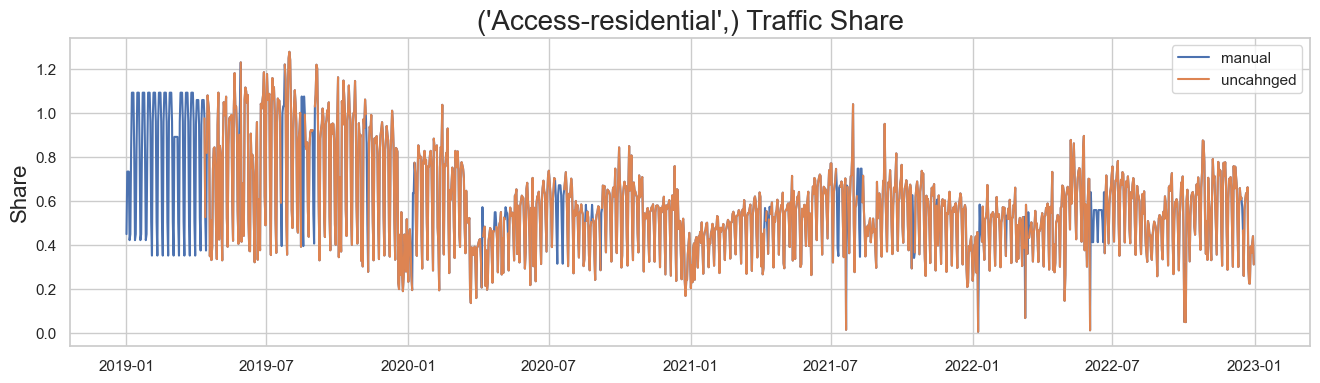

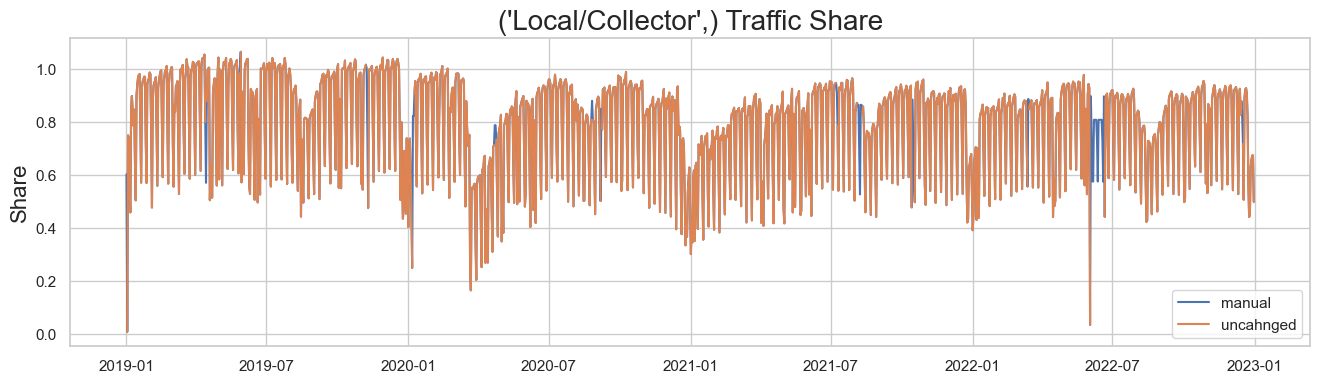

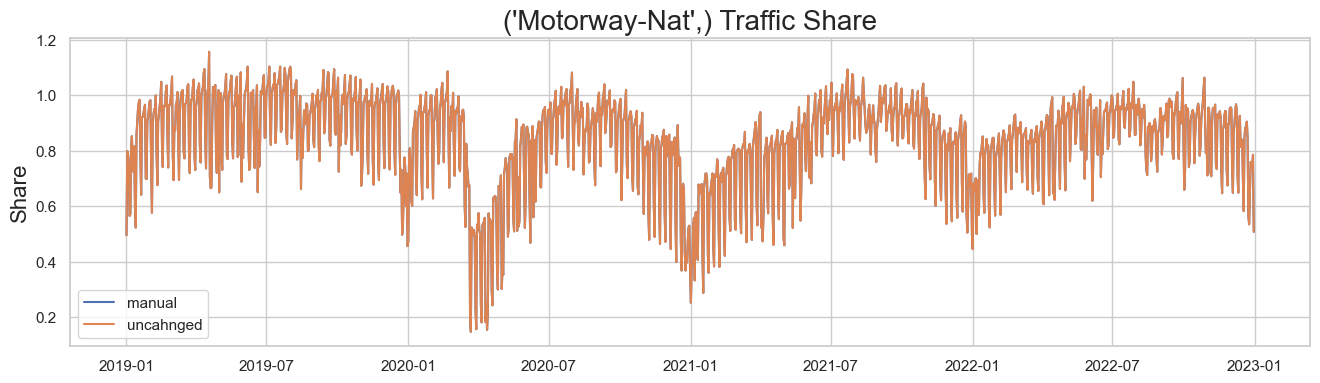

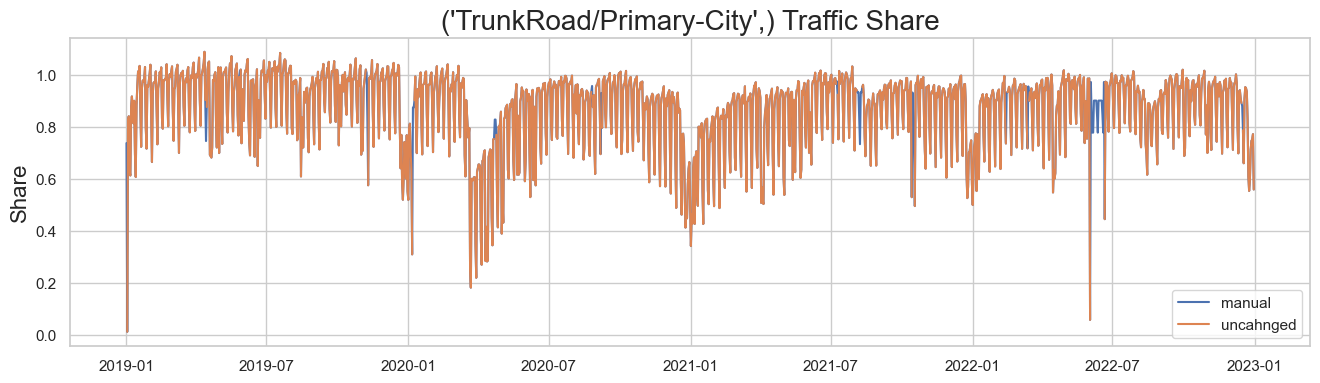

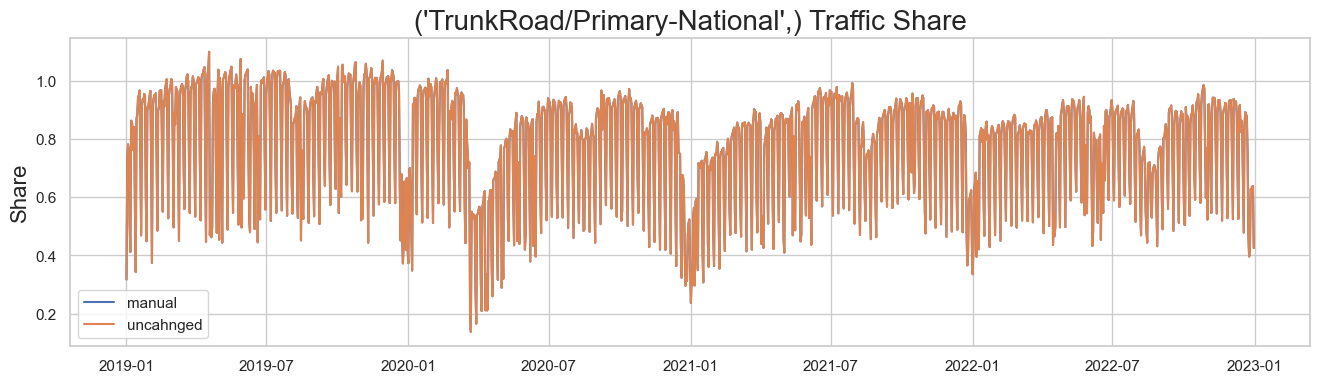

                       road_type       date  daily_value
0             Access-residential 2019-01-01     0.447625
1             Access-residential 2019-01-02     0.731980
2             Access-residential 2019-01-03     0.731980
3             Access-residential 2019-01-04     0.731980
4             Access-residential 2019-01-05     0.420116
...                          ...        ...          ...
7300  TrunkRoad/Primary-National 2022-12-27     0.627529
7301  TrunkRoad/Primary-National 2022-12-28     0.626349
7302  TrunkRoad/Primary-National 2022-12-29     0.635865
7303  TrunkRoad/Primary-National 2022-12-30     0.638028
7304  TrunkRoad/Primary-National 2022-12-31     0.425330

[7305 rows x 3 columns]


In [15]:
cal_obj = Calendar()
df = _counts.annual_cycles.reset_index()
filled_df = pd.DataFrame()
cycle_categories = ['road_type']  # Modify as per your dataset columns
cycle_value_column = 'daily_value'  # Modify as per your dataset
# Creating a date range from 2019-01-01 to 2022-12-31
date_range = pd.date_range(start='2019-01-01', end='2022-12-31')

# Create a template DataFrame with all combinations of categories and date
unique_categories = [df[category].unique() for category in cycle_categories]
all_combinations = product(*unique_categories, date_range)
template_df = pd.DataFrame(all_combinations, columns=cycle_categories + ['date'])

# Ensure 'date' column in df is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Merge the template DataFrame with the original DataFrame
merged_df = template_df.merge(df, on=cycle_categories + ['date'], how='left')
for category_values in product(*unique_categories):
        filter_condition = np.logical_and.reduce([merged_df[cat] == val for cat, val in zip(cycle_categories, category_values)])
        train_set = merged_df.loc[filter_condition].copy()
        unchanged_set = merged_df.loc[filter_condition].copy()
        first_non_nan = train_set[cycle_value_column].first_valid_index()
        day_types = {date:cal_obj.get_day_type_combined(date) for date in train_set['date']}
        train_set.insert(3, 'day_type',train_set['date'].map(day_types))
        if first_non_nan is not None:
            # Extract year and month from the date column
            train_set['year'] = train_set['date'].dt.year
            train_set['month'] = train_set['date'].dt.month

            # Group by year, month, and day_type, then calculate the mean
            mean_cycle_values = train_set.groupby(['year', 'month', 'day_type'])[cycle_value_column].mean()
            # Flatten the multi-index DataFrame
            mean_cycle_values = mean_cycle_values.reset_index()

            # Ensure that the DataFrame is sorted
            mean_cycle_values.sort_values(by=['year', 'day_type', 'month'], inplace=True)
            mean_cycle_values.set_index(['year', 'day_type', 'month'], inplace=True)

            # Calculate the rolling mean including one month before and after
            mean_cycle_values = mean_cycle_values[cycle_value_column].shift(1).rolling(window=3, min_periods=1).mean().shift(-2)
            mean_cycle_values.bfill(inplace=True)

            # Reset the index of mean_cycle_values
            mean_cycle_values = mean_cycle_values.reset_index()

            # Merge mean_cycle_values with avg_method
            train_set = pd.merge(train_set, mean_cycle_values, on=['year', 'day_type', 'month'], how='left', suffixes=('', '_mean'))

            # Fill NaN values in avg_method's daily_value with the mean values
            train_set['daily_value'].fillna(train_set['daily_value_mean'], inplace=True)

            # Optionally, if you don't want to keep the extra column:
            train_set=train_set.reset_index()
            train_set.drop(columns=['daily_value_mean','year','month','day_type','index'], inplace=True)
 

            filled_df = pd.concat([filled_df, train_set])

            train_set.set_index('date', inplace=True)
            
            # ARIMA
            #train_set = train_set.asfreq(pd.infer_freq(train_set.index))
            #arima = ARIMA(train_set[cycle_value_column], order=(5,0,3))
            #predictions = arima.fit().predict()
            
            
         
        plt.figure(figsize=(16, 4))
        #plt.plot(predictions, label="arima", linestyle = "--")
        plt.plot(train_set.index, train_set[cycle_value_column], label="manual")
        plt.plot(train_set.index, unchanged_set[cycle_value_column], label="uncahnged")
        plt.title(f"{category_values} Traffic Share", fontsize=20)
        plt.ylabel('Share', fontsize=16)
        plt.legend()
        plt.show()

filled_df.reset_index(inplace=True)
filled_df.drop(columns=['index'], inplace=True)
print(filled_df)


In [ ]:
def fill_gaps(df, categories, value_column, arima_order=(2, 0, 2)): 
    """
    Takes a DataFrame, creates a complete date range for each category combination,
    merges with the original dataset, and fills missing values using ARIMA.

    :param df: The DataFrame to process.
    :param categories: List of column names to define unique category combinations.
    :param value_column: Name of the column containing the values for ARIMA.
    :param arima_order: Order of the ARIMA model.
    """
    
    df = df.reset_index()
    # Creating a date range from 2019-01-01 to 2022-12-31
    date_range = pd.date_range(start='2019-01-01', end='2022-12-31')

    # Create a template DataFrame with all combinations of categories and date
    unique_categories = [df[category].unique() for category in categories]
    all_combinations = product(*unique_categories, date_range)
    template_df = pd.DataFrame(all_combinations, columns=categories + ['date'])

    # Ensure 'date' column in df is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Merge the template DataFrame with the original DataFrame
    merged_df = template_df.merge(df, on=categories + ['date'], how='left')

    # Fill missing values with ARIMA for each category combination
    for category_values in product(*unique_categories):
        filter_condition = np.logical_and.reduce([merged_df[cat] == val for cat, val in zip(categories, category_values)])
        train_set = merged_df.loc[filter_condition].copy()
        first_non_nan = train_set[value_column].first_valid_index()

        if first_non_nan is not None:
            train_set.loc[first_non_nan:, value_column].fillna(method='ffill', inplace=True)  # Forward fill
            train_set.set_index('date', inplace=True)
            train_set = train_set.asfreq(pd.infer_freq(train_set.index))

            arima = ARIMA(train_set[value_column], order=arima_order)
            predictions = arima.fit().predict()

            train_set[value_column].fillna(predictions, inplace=True)
            merged_df.loc[filter_condition, value_column] = train_set[value_column].values
            
        print(train_set)
        plt.figure(figsize=(16, 4))
        plt.plot(train_set.index, train_set[value_column], label="Actual")
        plt.plot(predictions, label="Predicted")
        plt.title(f"{category_values} Traffic Share", fontsize=20)
        plt.ylabel('Share', fontsize=16)
        plt.legend()
        plt.show()

    return merged_df


# For annual_cycle_counts
cycle_categories = ['road_type']  # Modify as per your dataset columns
cycle_value_column = 'daily_value'  # Modify as per your dataset
annual_cycles_counts_filled = fill_gaps(annual_cycles_counts, cycle_categories, cycle_value_column)

# Assume vehicle_share_counts and annual_cycle_counts are already loaded as DataFrames
vehicle_categories = ['road_type', 'vehicle_class']
vehicle_value_column = 0
vehicle_share_counts_filled = fill_gaps(vehicle_share_counts, vehicle_categories, vehicle_value_column